# Example
A high dimensional data set has monte carlo integration applied.

In [30]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

np.random.seed(0)

In [2]:
plt.style.use("illumina.mplstyle")

## Definitions
See introduction for explanation.

In [69]:
def monte_carlo_integrate(df, column, clf, n=100, Y=np.linspace(0, 1, 11), v=True):
    y_column = column  # The dimension to estimate kde of.
    y_index = df.columns.get_loc(y_column)  # The index of that dimension.
    f = lambda x: clf.predict_proba([x])[0][1]
    d = df.shape[1] # Number of dimensions.
    
    I = []
    for q in Y:
        q_val = []
        for i in range(n):
            # Draw random sample from the sample space.
            D = np.random.uniform(0, 1, d)
            D[y_index] = q

            # Append the density of the prediction at a point.
            prediction = f(D)
            q_val.append(prediction)

        q_val = sum(q_val) / n
        I.append(q_val)
        
    I = np.array(I)
    if v:
        print("Integration complete for", column)
    return I

In [59]:
def show_results(predictions, target):
    confusion = [tn, fp, fn, tp] = confusion_matrix(predictions, target).ravel()
    tn, fp, fn, tp = [i/len(preds) * 100 for i in confusion]
    print("Results separated for inspection.")
    print("+-------+----------+----------+")
    print("|       | Positive | Negative |")
    print("+-------+----------+----------+")
    print("| True  | {:7.3f}% | {:7.3f}% |".format(tp, tn))
    print("+-------+----------+----------+")
    print("| False | {:7.3f}% | {:7.3f}% |".format(fp, fn))
    print("+-------+----------+----------+")
    target = [1 if i == 'benign' else 0 for i in target]
    predictions = [1 if i == 'benign' else 0 for i in predictions]
    print("F1 score:", f1_score(target, predictions))

## Preprocessing

Load dataset. The breast cancer data set is used as it has a good number of samples for model training, and a number of dimensions that will result in a significantly difficult to interpret model.

In [60]:
iris = load_breast_cancer()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["species"] = pd.Categorical.from_codes(iris.target, iris.target_names)
print(df["species"].value_counts())
print(df.shape)
df.head()

benign       357
malignant    212
Name: species, dtype: int64
(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,species
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


Drop species as it is the target.

In [61]:
target = df["species"]
df = df.drop(["species"], axis=1)

Scale the data.

In [62]:
df = df.select_dtypes(include=np.number)
scaled = pd.DataFrame(MinMaxScaler().fit_transform(df))
scaled.columns = df.columns
scaled.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


Split into test and train

In [63]:
X_train, X_test, y_train, y_test = train_test_split(scaled, np.array(target), test_size=0.33, random_state=42)

## Random Forest

In [64]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [108]:
feature_importances = [i for i in zip(scaled.columns,
                       clf.feature_importances_)]

In [111]:
feature_importances.sort(key=lambda x: x[1])
feature_importances = feature_importances[::-1]

In [112]:
print(feature_importances)

[('worst perimeter', 0.14380603968632016), ('worst concave points', 0.12981371540768466), ('mean concave points', 0.12102699313867293), ('worst radius', 0.1030050724960254), ('mean concavity', 0.08809867855541688), ('worst area', 0.05913155719203133), ('mean perimeter', 0.05485506878660643), ('mean area', 0.043154330377091835), ('worst concavity', 0.02982108372626128), ('mean radius', 0.026352628838581183), ('area error', 0.025253424951467714), ('radius error', 0.023333767979499712), ('worst compactness', 0.01987748057458097), ('worst texture', 0.015004967482115742), ('mean texture', 0.014925582779200764), ('perimeter error', 0.014863923231188311), ('worst symmetry', 0.012355141629835342), ('worst smoothness', 0.010419843388944838), ('worst fractal dimension', 0.010350375528559282), ('mean fractal dimension', 0.006852379836370545), ('fractal dimension error', 0.006378189889669041), ('texture error', 0.006152516864361553), ('smoothness error', 0.005758037637485578), ('symmetry error', 0

In [113]:
preds = clf.predict(X_test)
certs = clf.predict_proba(X_test)

In [147]:
print(preds[1])
print(certs[1])

malignant
[0. 1.]


The first index of the prediction is used during monte carlo integration. The value of 0.03 here shows that the model is 97% certain that the breast is benign. Therefore later on, a value of -1 'indicates' benign and +1 'malignant'.

In [148]:
show_results(preds, y_test)

Results separated for inspection.
+-------+----------+----------+
|       | Positive | Negative |
+-------+----------+----------+
| True  |  32.447% |  62.766% |
+-------+----------+----------+
| False |   3.191% |   1.596% |
+-------+----------+----------+
F1 score: 0.963265306122449


Deconstruct the classifier into kernel density estimates of its certainty for each array.

In [120]:
Y = np.linspace(0, 1, 11)

In [115]:
kde = {col: monte_carlo_integrate(scaled, col, clf, Y=Y) for col in scaled.columns}

Integration complete for mean radius
Integration complete for mean texture
Integration complete for mean perimeter
Integration complete for mean area
Integration complete for mean smoothness
Integration complete for mean compactness
Integration complete for mean concavity
Integration complete for mean concave points
Integration complete for mean symmetry
Integration complete for mean fractal dimension
Integration complete for radius error
Integration complete for texture error
Integration complete for perimeter error
Integration complete for area error
Integration complete for smoothness error
Integration complete for compactness error
Integration complete for concavity error
Integration complete for concave points error
Integration complete for symmetry error
Integration complete for fractal dimension error
Integration complete for worst radius
Integration complete for worst texture
Integration complete for worst perimeter
Integration complete for worst area
Integration complete for w

## 1D KDE Visualization

Shift values back by 0.5 so that the 0 is the crossover of the 1D classifier.

In [87]:
viz_df_1d = pd.DataFrame({key: val - 0.5 for (key, val) in kde.items()})
viz_df_1d["Position"] = np.round(Y, 2)

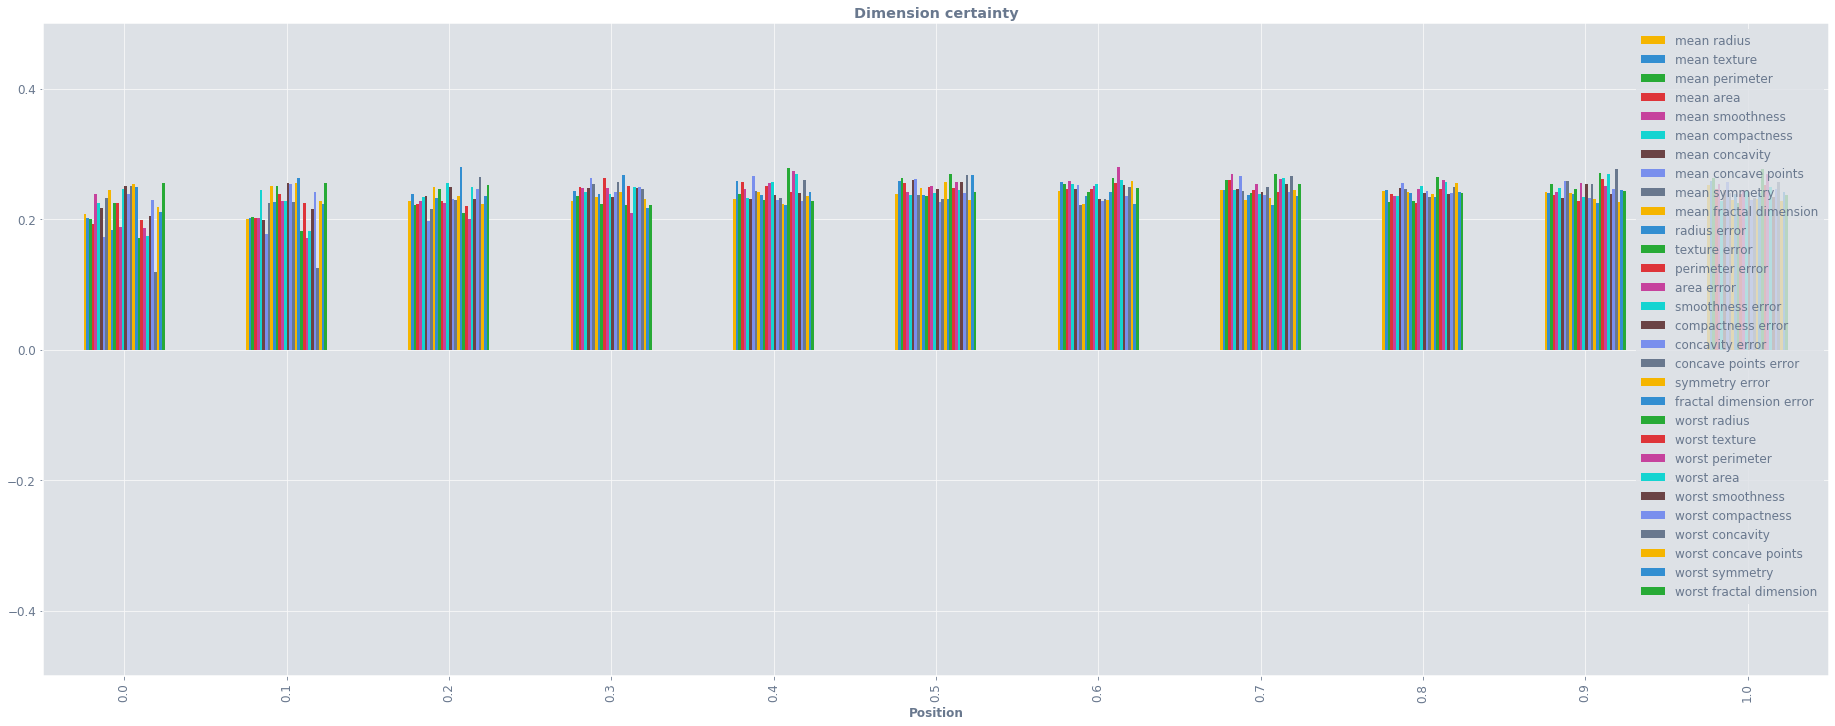

In [90]:
viz_df_1d.plot.bar(ylim=(-0.5, 0.5), x="Position", title="Dimension certainty", figsize=(32, 12))

## 2D KDE Visualization

In [117]:
feature_importances[:2]

[('worst perimeter', 0.14380603968632016),
 ('worst concave points', 0.12981371540768466)]

In [162]:
ft1 = feature_importances[1][0]
ft2 = feature_importances[3][0]

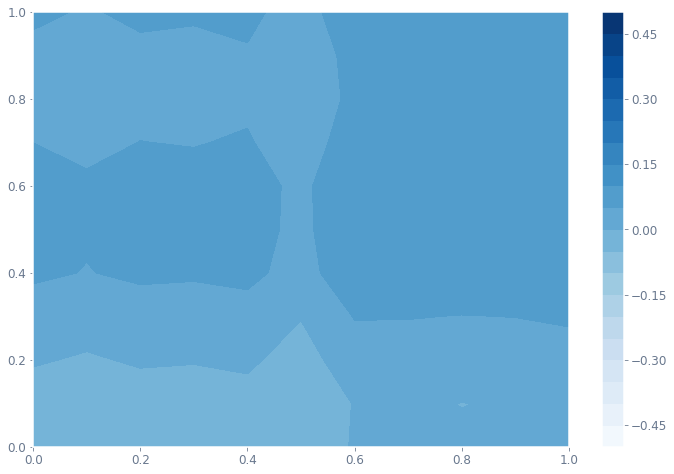

In [163]:
Xm, Ym = np.meshgrid(Y, Y)
Zm = [[(i*j)-0.5 for i in kde[ft1]] for j in kde[ft2]]
contours = plt.contourf(Xm, Ym, Zm, levels=np.linspace(-0.5, 0.5, 21))
# plt.clabel(contours, inline=True)
plt.colorbar();